In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def plc(f_ref, f, a_ref=1.0, a=None):
    # Plompt-Levelt dissonance curve for sinusoidal tones; f_ref is the base frequency with amplitude a_ref
    #  f is a list of frequencies with amplitude values in a
    A1, A2, C1, C2 = -3.51, -5.75, 5.0, -5.0
    D, S1, S2 = 0.24, 0.0207, 18.96
    d = np.abs(f_ref - f) * D / (S1 * np.minimum(f_ref, f) + S2)
    a = np.minimum(a_ref, 1.0) if a is None else np.minimum(a_ref, a)
    return (C1 * np.exp(A1 * d) + C2 * np.exp(A2 * d)) * a

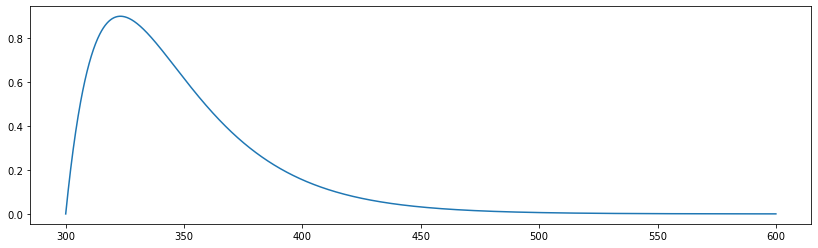

In [7]:
f1 = 300
f = np.linspace(f1, 2*f1, 2000)
plt.plot(f, plc(f1, f, a_ref=10));
#print( plc(f1, f, a_ref=10))

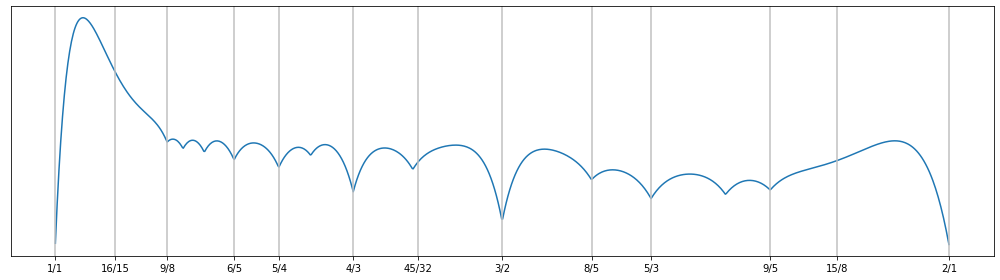

In [5]:
partials = np.arange(1, 10)
amplitudes = 0.88 ** (partials - 1)

f0 = 500
steps = np.linspace(1, 2, 1000)

d = np.zeros(len(steps), dtype=float)
for i, alpha in enumerate(steps):
    for j, f_ref in enumerate(f0 * partials):
        d[i] += np.sum(plc(f_ref, f0 * alpha * partials, a_ref=amplitudes[j], a=amplitudes))

        
plt.rcParams["figure.figsize"] = (14,4)

plt.plot(steps, d)    
#plt.xscale('log')
intervals = [(1, 1), (16, 15), (9,8), (6, 5), (5, 4), (4, 3), (45, 32), (3, 2), (8, 5), (5, 3), (9, 5), (15, 8), (2, 1)]

#1/1	16/15	9/8	6/5	5/4 	4/3	45/32	3/2	8/5	5/3 	9/5	15/8	2/1
for n, d in intervals:
    plt.axvline(n/d, color='silver')
plt.yticks([])
plt.minorticks_off()
plt.xticks([n/d for n, d in intervals],
           ['{}/{}'.format(n, d) for n, d in intervals])
plt.tight_layout()
plt.show()    

In [14]:
e = np.array([(2 ** (n/12)) for n in range(0, 20)])
b = np.array([(3 ** (n/13)) for n in range(0, 14)])

In [16]:
d = []
for t in b:
    d.append(np.min(np.abs(e-t)))

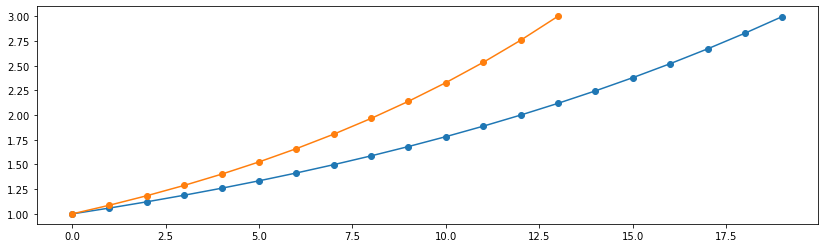

In [17]:
plt.plot(e, 'o-')
plt.plot(b, 'o-')

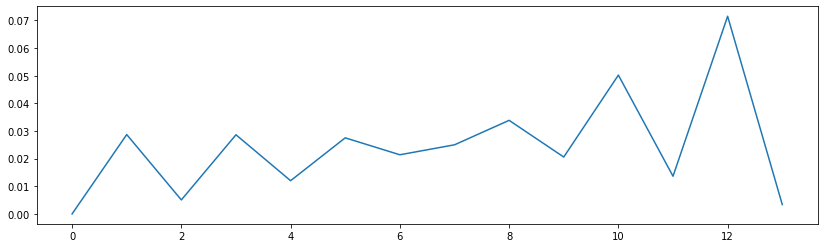

In [18]:
plt.plot(d)

In [49]:
import IPython

In [83]:
DEFAULT_SF = 32000

class Synthesizer:
    """
    Simple monophonic synthesizer with different tunings and waveform engines.
    Input format is a lists of note/duration pairs, eg [('C4', 2), ('E4', 1), ('G4', 1)], which
    will be converted into an internal representation of frequency/duration pairs (fdp) according
    to the selected tuning; for instance, the fdp representation of the above line is
        array([[261.63      , 329.63314428, 392.00208052],
               [  2.        ,   1.        ,   1.        ]])
    FDP's are useful for transposition and can be used directly in case of non-standard pitches.
    """

    SF = DEFAULT_SF
    C4 = 261.63
    SEMITONES = {'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3, 'E': 4, 'F': 5, 'F#': 6, 'Gb': 6, 
                 'G': 7, 'G#': 8, 'Ab': 8, 'A': 9, 'A#': 10, 'Bb': 10, 'B': 11}  
    TUNINGS = {
        'equal': [2.0 ** (n / 12.0) for n in range(0, 12)],
        'just' : [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8],
        'pythagorean': [1, 256/243, 9/8, 32/27, 81/64, 4/3, 729/512, 3/2, 128/81, 27/16, 16/9, 243/128],
    }
    
    time_scale = 0.35  
    tuning = 'equal'
    
    @classmethod
    def taper(cls, x, len_sec=0.005):
        """Taper audio data to zero at both ends"""
        N = int(len_sec * cls.SF)
        x[0:N] *= np.linspace(0, 1, N)
        x[-N:] *= np.linspace(1, 0, N)
        return x
    
    @classmethod
    def glissando(cls, start, stop, len_sec):
        """Create a linear chirp with specific range and duration"""
        N = int(len_sec * cls.SF)
        c = (stop - start) / N / 2
        n = np.arange(0, N)
        chirp = np.cos(2 * np.pi / cls.SF * (c * n + start) * n)
        return cls.taper(chirp)

    # waveform engines; these functions take a digital frequency and a duration in samples
    def sas(self, w, N):
        """Simple additive synthesis"""
        x = np.zeros(N)
        for k, p in enumerate([0.6, 0.5, 0.3, 0.4, 0.1]):
            x += p * np.sin(k * w * np.arange(0, N))
        return x
    
    def sine(self, w, N):
        return np.sin(np.arange(0, N) * w)
    
    ENGINES = {
        'additive': sas,
        'sine': sine
    }
    
    def __init__(self, tuning='equal', SF=DEFAULT_SF):
        assert tuning in self.TUNINGS.keys(), 'Unknown tuning/intonation'
        self.tuning = tuning
        self.SF = float(SF)
    
    def parse(self, notes, tuning=None) -> 'frequency/time pairs':
        """Convert a series of notes into frequency/time pairs using a specific tuning"""
        # if format is already FTP no need to convert
        if isinstance(notes, np.ndarray) and notes.ndim == 2:
            return notes
        tuning = tuning or self.tuning
        assert tuning in self.TUNINGS.keys(), 'Unknown tuning/intonation'
        ftp = np.zeros((2, len(notes)))
        for ix, note in enumerate(notes): 
            # if not specified, default duration is 1
            note = note if isinstance(note, tuple) else (note, 1.0)
            if isinstance(note[0], str):
                # convert notation to frequency
                s = self.SEMITONES[note[0][:-1]]
                octave = int(note[0][-1]) - 4
                ftp[0][ix] = self.C4 * (2 ** octave) * self.TUNINGS[tuning][s]
            else:
                ftp[0][ix] = note[0]
            ftp[1][ix] = note[1]
        return ftp
        
    def play(self, score, time_scale=None, engine=None, tuning=None):
        """
        Syntesize audio data from a melody line (either in note/duration format or in frequency/duration 2xN array)
        time_scale adjusts the timebase
        engine selects the waveform generator
        tuning selects the tuning for melodies expressed with note names
        """
        engine = engine or 'additive'
        time_scale = time_scale or self.time_scale
        ftp = self.parse(score, tuning)
        s = np.array([])
        for n in range(0, len(ftp[0])):
            w = 2 * np.pi * ftp[0][n] / self.SF
            N = int(ftp[1][n] * self.SF * time_scale)
            s = np.r_[s, self.taper(self.ENGINES[engine](self, w, N))]
        return s

In [84]:
frere_jacques = (('C4', 1), ('D4', 1), ('E4', 1), ('C4', 1), ('C4', 1), ('D4', 1), ('E4', 1), ('C4', 1), ('E4', 1), 
                 ('F4', 1), ('G4', 2), ('E4', 1), ('F4', 1), ('G4', 2))

fda = Synthesizer().parse(frere_jacques, tuning='equal')

IPython.display.Audio(Synthesizer().play(fda * [[2 ** (-2.2)], [1]], engine='sine'), rate=Synthesizer().SF)

In [85]:
Synthesizer().parse([('C4', 2), ('E4', 1), ('G4', 1)])

array([[261.63      , 329.63314428, 392.00208052],
       [  2.        ,   1.        ,   1.        ]])

In [86]:
loop = [('Eb2', 1), (0, 1), ('Bb1', 1), (0, 1), ('F1', 1), (0, 1), ('Ab1', 1), (0, 1), ('Ab1', 1), (0, 3), ('E1', 1), (0, 3),  ]
IPython.display.Audio(Synthesizer().play(loop, engine='sine', time_scale=0.1), rate=Synthesizer().SF)

In [42]:
import numpy as np

a = np.log(3) / np.log(2)

dmin = 10
for n in range(12, 20000):
    kt = int(0.58 * n)
    kr = int(10 * max(1, np.log(n) - 3))
    for k in range(kt-kr, kt+kr):
        try:
            #d = abs(np.power(1.5, n) * np.power(2.0, -k) - 1)
            d = abs((3 ** n) / (2 ** (n+k)) - 1)
            if d < dmin:
                dmin = d
                print(dmin, n, k)
        except OverflowError:
            print(n, k, kt)

7.1091461181640625 12 4
3.0545730590820312 12 5
1.0272865295410156 12 6
0.013643264770507812 12 7
0.011397452270387465 41 24
0.002090314041086172 53 31
0.0010217168234779583 306 179
4.365506344328196e-05 665 389


<ipython-input-42-81882f0377f5>:11: RuntimeWarning: overflow encountered in power
  d = abs(np.power(1.5, n) * np.power(2.0, -k) - 1)
<ipython-input-42-81882f0377f5>:11: RuntimeWarning: invalid value encountered in double_scalars
  d = abs(np.power(1.5, n) * np.power(2.0, -k) - 1)


In [45]:
import numpy as np

b = (np.log(3) / np.log(2) - 1)
dmin, vmin = 10, 10
for n in range(12, 100000):
    kt = int(0.58 * n)
    kr = int(10 * max(1, np.log(n) - 3))
    for k in range(max(7, kt-kr), kt+kr):
        d = np.abs((k / n) - b)
        if d < dmin:
            print(dmin, n, k, vmin)
            v = abs(np.power(1.5, n) * np.power(2.0, -k) - 1)
            if v < vmin:
                dmin, vmin = d, v
                print(dmin, n, k, vmin)

10 12 7 10
0.0016291673878229274 12 7 0.013643264770507812
0.0016291673878229274 29 17 0.013643264770507812
0.0016291673878229274 41 24 0.013643264770507812
0.00040335293738025246 41 24 0.011397452270387465
0.00040335293738025246 53 31 0.011397452270387465
5.684034379782599e-05 53 31 0.002090314041086172
5.684034379782599e-05 200 117 0.002090314041086172
5.684034379782599e-05 253 148 0.002090314041086172
5.684034379782599e-05 306 179 0.002090314041086172
4.8195402816419985e-06 306 179 0.0010217168234779583
4.8195402816419985e-06 359 210 0.0010217168234779583
4.8195402816419985e-06 665 389 0.0010217168234779583
9.470611872508528e-08 665 389 4.365506344328196e-05
9.470611872508528e-08 8286 4847 4.365506344328196e-05
9.470611872508528e-08 8951 5236 4.365506344328196e-05
9.470611872508528e-08 9616 5625 4.365506344328196e-05


<ipython-input-45-5e081ca5df29>:12: RuntimeWarning: overflow encountered in power
  v = abs(np.power(1.5, n) * np.power(2.0, -k) - 1)
<ipython-input-45-5e081ca5df29>:12: RuntimeWarning: invalid value encountered in double_scalars
  v = abs(np.power(1.5, n) * np.power(2.0, -k) - 1)


9.470611872508528e-08 10281 6014 4.365506344328196e-05
9.470611872508528e-08 10946 6403 4.365506344328196e-05
9.470611872508528e-08 11611 6792 4.365506344328196e-05
9.470611872508528e-08 12276 7181 4.365506344328196e-05
